In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
data = pd.read_csv("satis_verisi_5000.csv")
musteri_data = pd.read_csv("musteri_verisi_5000_utf8.csv")

In [3]:
data['tarih'] = pd.to_datetime(data['tarih'])
data = data.drop('Unnamed: 0', axis=1)
data


,tarih,ürün_kodu,ürün_adi,kategori,fiyat,adet,toplam_satis,musteri_id
0,2023-07-02,P032,Mouse,Elektronik,1207.3,13,15694.9,9225
1,2024-02-11,P011,Kalem,Kırtasiye,237.14,16,3794.24,3955
2,2023-03-06,P024,Bilgisayar,Elektronik,1024.29,9,9218.61,2367
3,2024-04-11,P063,Klima,Elektronik,1477.88,9,13300920000000000,2869
4,2024-01-08,P063,Klima,Elektronik,949.43,19,18039.17,9724
...,...,...,...,...,...,...,...,...
4995,2023-06-11,P037,Fırın,Ev Aletleri,1425.17,16,22802.72,2855
4996,2024-09-11,P032,Mouse,Elektronik,773.54,12,9282.48,2599
4997,2024-08-26,P087,Kulaklık,Elektronik,603.25,15,9048.75,3648
4998,2023-10-11,P097,Su Şişesi,Mutfak Ürünleri,957.64,9,8618.76,8979


# 1. Soru

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   tarih         5000 non-null   datetime64[ns]
 1   ürün_kodu     5000 non-null   object        
 2   ürün_adi      5000 non-null   object        
 3   kategori      5000 non-null   object        
 4   fiyat         5000 non-null   object        
 5   adet          5000 non-null   int64         
 6   toplam_satis  5000 non-null   object        
 7   musteri_id    5000 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 312.6+ KB


In [5]:
data['toplam_satis'] = pd.to_numeric(data['toplam_satis'], errors='coerce')
data['fiyat'] = pd.to_numeric(data['fiyat'], errors='coerce')

In [6]:
print(data[data.fiyat.isna()|data.toplam_satis.isna()])

          tarih ürün_kodu    ürün_adi         kategori  fiyat  adet  \
159  2023-10-23      P018     Telefon       Elektronik    NaN     5   
195  2023-05-18      P063       Klima       Elektronik    NaN    13   
217  2023-03-23      P018     Telefon       Elektronik    NaN    13   
250  2023-09-13      P032       Mouse       Elektronik    NaN    12   
485  2024-10-30      P010       Çanta            Giyim    NaN    15   
566  2024-05-03      P011       Kalem        Kırtasiye    NaN    10   
656  2023-12-30      P063       Klima       Elektronik    NaN    19   
726  2024-04-11      P011       Kalem        Kırtasiye    NaN    16   
746  2024-05-24      P087    Kulaklık       Elektronik    NaN    15   
766  2024-09-12      P010       Çanta            Giyim    NaN    19   
770  2024-09-30      P010       Çanta            Giyim    NaN    13   
794  2022-11-25      P097   Su Şişesi  Mutfak Ürünleri    NaN     1   
1125 2022-12-08      P082      Defter        Kırtasiye    NaN     9   
1260 2

In [8]:
# Eksik değerleri olan satırları seç
missing_data = data[data.fiyat.isna() | data.toplam_satis.isna()].copy()

# Sadece `fiyat` sütunu eksik olan durumlarda `fiyat` hesapla
missing_data.loc[missing_data.fiyat.isna() & missing_data.toplam_satis.notna(), 'fiyat'] = (
    missing_data['toplam_satis'] / missing_data['adet']
)

# Hem `fiyat` hem `toplam_satis` eksikse `fiyat`ı ortalama ile doldur
missing_data.loc[missing_data.toplam_satis.isna(), 'fiyat'] = missing_data['ürün_kodu'].map(
    lambda x: data[data['ürün_kodu'] == x]['fiyat'].mean()
)

# Eksik `toplam_satis` değerlerini `adet * fiyat` olarak hesapla
missing_data['toplam_satis'] = missing_data['adet'] * missing_data['fiyat']

# Orijinal DataFrame'i güncelle
data.update(missing_data)

In [9]:
print(data.isna().sum())

tarih           0
ürün_kodu       0
ürün_adi        0
kategori        0
fiyat           0
adet            0
toplam_satis    0
musteri_id      0
dtype: int64


In [10]:
data[data['fiyat'] * data['adet'] != data['toplam_satis']]

,tarih,ürün_kodu,ürün_adi,kategori,fiyat,adet,toplam_satis,musteri_id
3,2024-04-11,P063,Klima,Elektronik,1477.880,9,13300920000000000.000,2869
12,2024-03-20,P024,Bilgisayar,Elektronik,1302.350,7,9116.450,2863
13,2023-09-01,P063,Klima,Elektronik,270.140,13,3511.820,6923
15,2024-06-08,P082,Defter,Kırtasiye,1221.370,6,7328219999999990.000,4666
23,2024-09-16,P032,Mouse,Elektronik,926.760,3,2780.280,4046
...,...,...,...,...,...,...,...,...
4972,2023-02-21,P037,Fırın,Ev Aletleri,547.830,3,16434900000000000.000,4003
4973,2024-10-13,P024,Bilgisayar,Elektronik,1168.060,15,17520899999999900.000,7952
4974,2024-05-05,P087,Kulaklık,Elektronik,190.610,9,17154900000000000.000,8158
4982,2023-07-23,P037,Fırın,Ev Aletleri,379.540,3,1138.620,3792


In [11]:
data[data.toplam_satis>2.5*data.toplam_satis.mean()]

,tarih,ürün_kodu,ürün_adi,kategori,fiyat,adet,toplam_satis,musteri_id
3,2024-04-11,P063,Klima,Elektronik,1477.880,9,13300920000000000.000,2869
15,2024-06-08,P082,Defter,Kırtasiye,1221.370,6,7328219999999990.000,4666
27,2024-03-31,P082,Defter,Kırtasiye,420.900,3,12626999999999900.000,7110
31,2023-11-08,P063,Klima,Elektronik,1142.150,3,34264500000000000.000,9142
40,2024-05-24,P010,Çanta,Giyim,352.220,18,6339960000000000.000,7099
...,...,...,...,...,...,...,...,...
4967,2023-08-21,P024,Bilgisayar,Elektronik,955.050,6,5730299999999990.000,2840
4972,2023-02-21,P037,Fırın,Ev Aletleri,547.830,3,16434900000000000.000,4003
4973,2024-10-13,P024,Bilgisayar,Elektronik,1168.060,15,17520899999999900.000,7952
4974,2024-05-05,P087,Kulaklık,Elektronik,190.610,9,17154900000000000.000,8158


In [12]:
data[data.fiyat>2.5*data.fiyat.mean()]

,tarih,ürün_kodu,ürün_adi,kategori,fiyat,adet,toplam_satis,musteri_id
746,2024-05-24,P087,Kulaklık,Elektronik,1176999999999993.250,15,17654999999999898.000,7215
1125,2022-12-08,P082,Defter,Kırtasiye,846000000000000.000,9,7614000000000000.000,4365
1651,2024-04-16,P032,Mouse,Elektronik,5410000000000000.000,11,59510000000000000.000,1934
2432,2022-11-15,P011,Kalem,Kırtasiye,946000000000000.000,13,12298000000000000.000,9692
4564,2024-03-26,P082,Defter,Kırtasiye,5669999999999967.000,3,17009999999999900.000,1572


In [13]:
# Ortalama fiyatın 2.5 katından büyük olan verileri filtrele
mask = data['fiyat'] > 2.5 * data['fiyat'].mean()

# Şartı sağlayan veriler için işlem yap
data.loc[mask, 'fiyat'] = data.loc[mask, 'fiyat'].apply(
    lambda x: x / 10**12 if x / 10**12 < 1500 else x / 10**13
)

In [14]:
data['toplam_satis'] = data['fiyat']*data['adet']

In [15]:
merged_data = pd.merge(data,
                       musteri_data, 
                       on='musteri_id', 
                       how='inner')

In [16]:
print(merged_data.head())

       tarih ürün_kodu    ürün_adi         kategori    fiyat  adet  \
0 2023-07-02      P032       Mouse       Elektronik 1207.300    13   
1 2024-02-11      P011       Kalem        Kırtasiye  237.140    16   
2 2023-05-13      P097   Su Şişesi  Mutfak Ürünleri  671.200    15   
3 2024-05-28      P011       Kalem        Kırtasiye  758.330     8   
4 2023-03-06      P024  Bilgisayar       Elektronik 1024.290     9   

   toplam_satis  musteri_id    isim cinsiyet  yas     sehir  harcama_miktari  
0     15694.900        9225  Masume    Kadın   35  İstanbul         3588.150  
1      3794.240        3955   Fenni    Kadın   64     Konya         3742.460  
2     10068.000        3955   Fenni    Kadın   64     Konya         3742.460  
3      6066.640        3955   Fenni    Kadın   64     Konya         3742.460  
4      9218.610        2367  Feyruz    Kadın   45     Bursa          197.550  


# 2. Soru

In [17]:
merged_data['hafta'] = merged_data['tarih'].dt.isocalendar().week  # Haftalık bilgi
merged_data['ay'] = merged_data['tarih'].dt.month  # Ay bilgisini ekleyin
merged_data['gün'] = merged_data['tarih'].dt.dayofweek  # Haftanın günü
merged_data['yil'] = merged_data['tarih'].dt.year

In [18]:
print(merged_data.head())

       tarih ürün_kodu    ürün_adi         kategori    fiyat  adet  \
0 2023-07-02      P032       Mouse       Elektronik 1207.300    13   
1 2024-02-11      P011       Kalem        Kırtasiye  237.140    16   
2 2023-05-13      P097   Su Şişesi  Mutfak Ürünleri  671.200    15   
3 2024-05-28      P011       Kalem        Kırtasiye  758.330     8   
4 2023-03-06      P024  Bilgisayar       Elektronik 1024.290     9   

   toplam_satis  musteri_id    isim cinsiyet  yas     sehir  harcama_miktari  \
0     15694.900        9225  Masume    Kadın   35  İstanbul         3588.150   
1      3794.240        3955   Fenni    Kadın   64     Konya         3742.460   
2     10068.000        3955   Fenni    Kadın   64     Konya         3742.460   
3      6066.640        3955   Fenni    Kadın   64     Konya         3742.460   
4      9218.610        2367  Feyruz    Kadın   45     Bursa          197.550   

   hafta  ay  gün   yil  
0     26   7    6  2023  
1      6   2    6  2024  
2     19   5    5  2

Text(0.5, 1.0, 'Aylık Toplam Satış Grafiği')

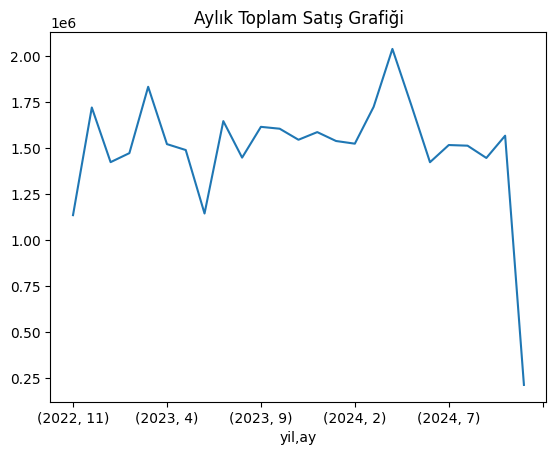

In [19]:
merged_data.groupby(['yil','ay'])['toplam_satis'].sum().plot()
plt.title('Aylık Toplam Satış Grafiği')

Text(0.5, 1.0, 'Haftalık Toplam Satış Grafiği')

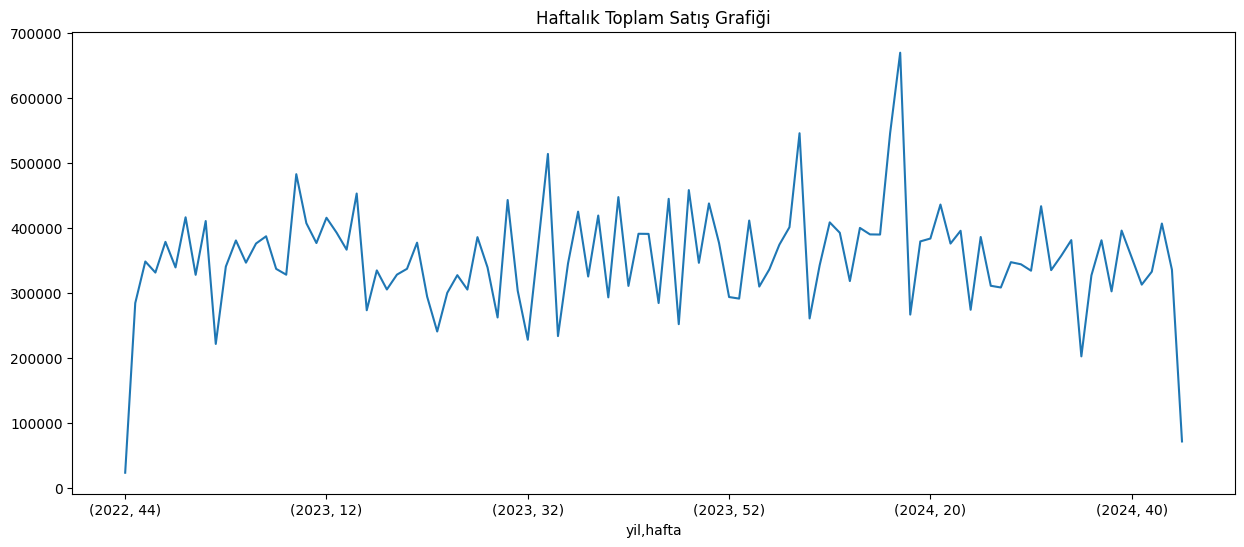

In [20]:
merged_data.groupby(['yil','hafta'])['toplam_satis'].sum().plot(figsize=(15,6))
plt.title('Haftalık Toplam Satış Grafiği')

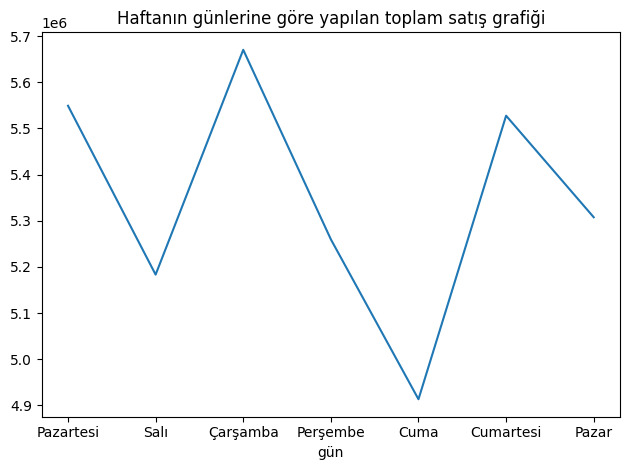

In [21]:
merged_data.groupby('gün')['toplam_satis'].sum().plot()
plt.title('Haftanın günlerine göre yapılan toplam satış grafiği')
plt.xticks(ticks=range(7), labels=['Pazartesi', 'Salı', 'Çarşamba', 'Perşembe', 'Cuma', 'Cumartesi', 'Pazar'])
plt.tight_layout()


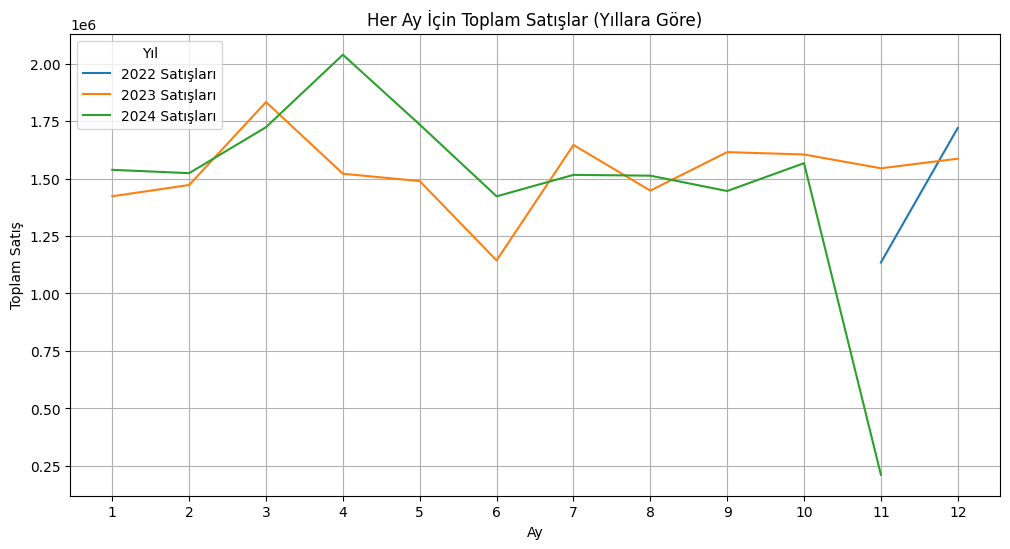

In [22]:
# Yıl ve ay bilgisiyle gruplama yaparak toplam satışları hesaplıyoruz
monthly_sales = merged_data.groupby(['yil', 'ay']).agg({'toplam_satis': 'sum'}).reset_index()

# Plotlama işlemi
plt.figure(figsize=(12, 6))

# Her yıl için farklı renklerde çizim yapmak
for year in monthly_sales['yil'].unique():
    year_data = monthly_sales[monthly_sales['yil'] == year]
    plt.plot(year_data['ay'], year_data['toplam_satis'], label=f'{year} Satışları')

# Grafik başlıkları ve etiketler
plt.title('Her Ay İçin Toplam Satışlar (Yıllara Göre)')
plt.xlabel('Ay')
plt.ylabel('Toplam Satış')
plt.xticks(range(1, 13))  # Ayları 1'den 12'ye kadar göster
plt.legend(title='Yıl')
plt.grid(True)

# Grafiği göster
plt.show()

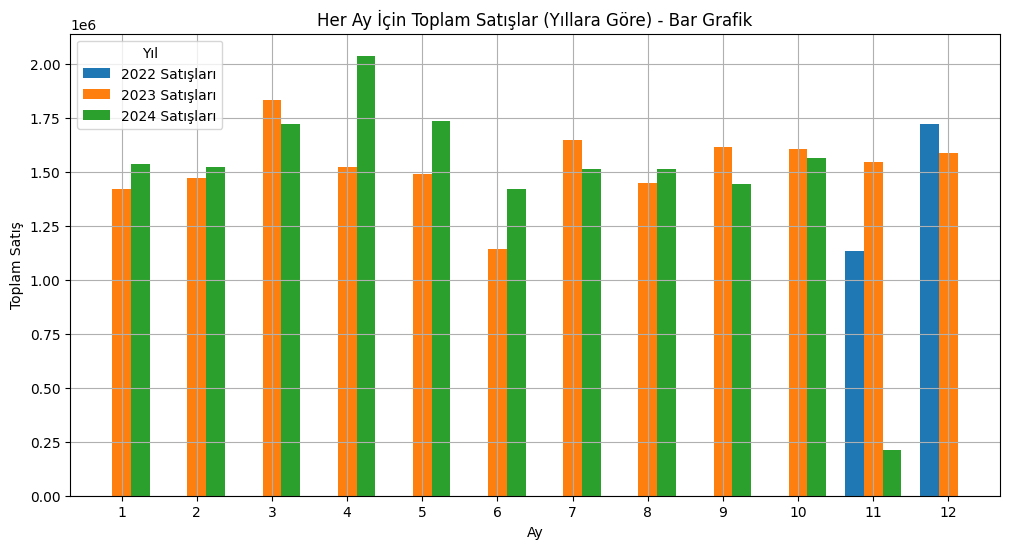

In [23]:
import matplotlib.pyplot as plt

# Yıl ve ay bilgisiyle gruplama yaparak toplam satışları hesaplıyoruz
monthly_sales = merged_data.groupby(['yil', 'ay']).agg({'toplam_satis': 'sum'}).reset_index()

# Grafik oluşturma
plt.figure(figsize=(12, 6))

# Bar genişliği
width = 0.25  # Çubuk genişliği

# Yıllara göre barları yerleştirme
for i, year in enumerate(sorted(monthly_sales['yil'].unique())):
    year_data = monthly_sales[monthly_sales['yil'] == year]
    
    # Çubukları doğru yerleştirmek için her yılın çubuğuna offset ekliyoruz
    # Her yıl için barları kaydırıyoruz (offset değeri)
    offset = i - (len(sorted(monthly_sales['yil'].unique())) - 1) / 2
    
    # Barları çiziyoruz
    plt.bar(year_data['ay'] + offset * width, year_data['toplam_satis'], width=width, label=f'{year} Satışları')

# Grafik başlıkları ve etiketler
plt.title('Her Ay İçin Toplam Satışlar (Yıllara Göre) - Bar Grafik')
plt.xlabel('Ay')
plt.ylabel('Toplam Satış')
plt.xticks(range(1, 13))  # Ayları 1'den 12'ye kadar göster
plt.legend(title='Yıl')
plt.grid(True)

# Grafiği göster
plt.show()


In [24]:
# Yıl ve Ay bilgisiyle grup yaparak ilk ve son satış tarihlerini elde etme
monthly_sales = merged_data.groupby(['yil', 'ay']).agg(
    first_sale_date=('tarih', 'min'),
    last_sale_date=('tarih', 'max')
).reset_index()

# İlk ve son satış tarihindeki tüm satışları toplama fonksiyonu
def get_total_sales_on_date(group, date):
    # Bu tarihteki tüm satışları toplar
    sales_on_date = group[group['tarih'] == date]['toplam_satis']
    return sales_on_date.sum()

# İlk ve son satış tarihlerindeki satışları hesaplama
monthly_sales['first_day_total'] = monthly_sales.apply(
    lambda row: get_total_sales_on_date(
        merged_data[(merged_data['yil'] == row['yil']) & (merged_data['ay'] == row['ay'])], 
        row['first_sale_date']
    ), axis=1
)

monthly_sales['last_day_total'] = monthly_sales.apply(
    lambda row: get_total_sales_on_date(
        merged_data[(merged_data['yil'] == row['yil']) & (merged_data['ay'] == row['ay'])], 
        row['last_sale_date']
    ), axis=1
)

In [25]:
print(monthly_sales)

     yil  ay first_sale_date last_sale_date  first_day_total  last_day_total
0   2022  11      2022-11-06     2022-11-30        22763.970       49280.300
1   2022  12      2022-12-01     2022-12-31        67859.800       42447.330
2   2023   1      2023-01-01     2023-01-31        38372.900       53574.580
3   2023   2      2023-02-01     2023-02-28        66131.170       93778.950
4   2023   3      2023-03-01     2023-03-31        49208.750       40418.010
5   2023   4      2023-04-01     2023-04-30        31586.430        2043.340
6   2023   5      2023-05-01     2023-05-31        52525.920       37518.700
7   2023   6      2023-06-01     2023-06-30        42593.050        2602.380
8   2023   7      2023-07-01     2023-07-31        94599.850       40468.650
9   2023   8      2023-08-01     2023-08-31        16374.220        9320.480
10  2023   9      2023-09-01     2023-09-30        32424.550       36409.330
11  2023  10      2023-10-01     2023-10-31        54468.180       49508.290

<Axes: xlabel='yil,hafta'>

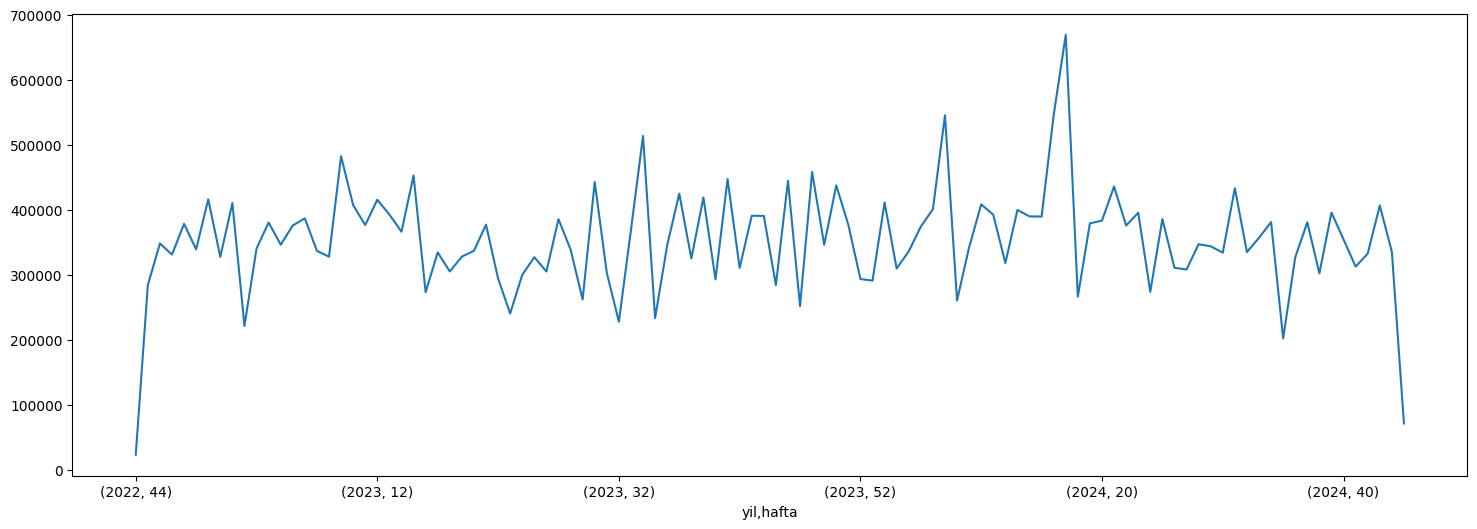

In [26]:
weekly_sales = merged_data.groupby(['yil','hafta'])['toplam_satis'].sum()
weekly_sales.plot(figsize=(18,6))

<Axes: xlabel='tarih'>

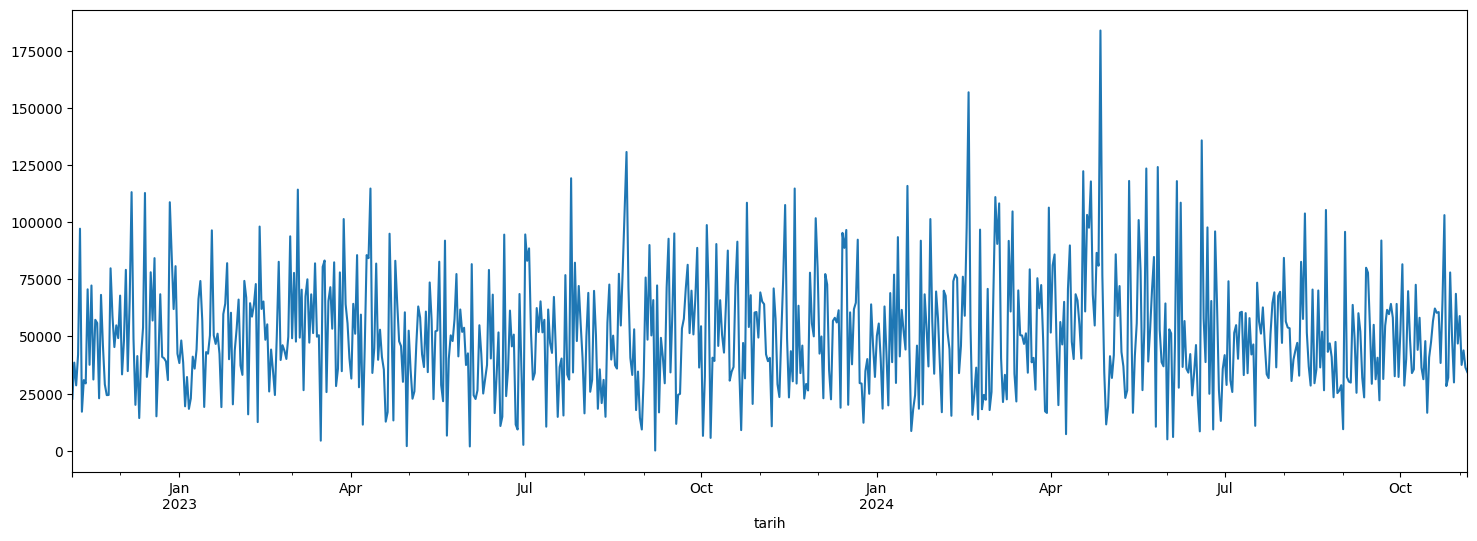

In [27]:
merged_data.groupby('tarih')['toplam_satis'].sum().plot(figsize=(18,6))

In [28]:
# Group data by 'yil' and 'ay', summing up 'toplam_satis'
monthly_sales_diff = merged_data.groupby(['yil', 'ay'])['toplam_satis'].sum().reset_index()

# Calculate the difference by shifting the 'toplam_satis' column and subtracting
monthly_sales_diff['difference'] = monthly_sales_diff['toplam_satis'].diff()

# Slice starting from the second row to skip the NaN in the first difference
monthly_sales_difference = monthly_sales_diff[1:]

<Axes: >

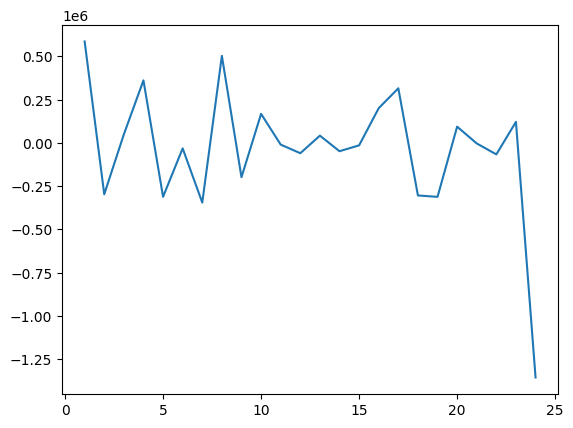

In [29]:
monthly_sales_difference.difference.plot()

# 3. soru

In [30]:
print(merged_data.groupby('kategori')[['toplam_satis', 'adet']].sum())

                 toplam_satis   adet
kategori                            
Elektronik       18155111.582  24512
Ev Aletleri       3791498.810   4833
Giyim             3884420.600   5253
Kırtasiye         7819094.520  10502
Mutfak Ürünleri   3761493.736   5259


Text(0, 0.5, '')

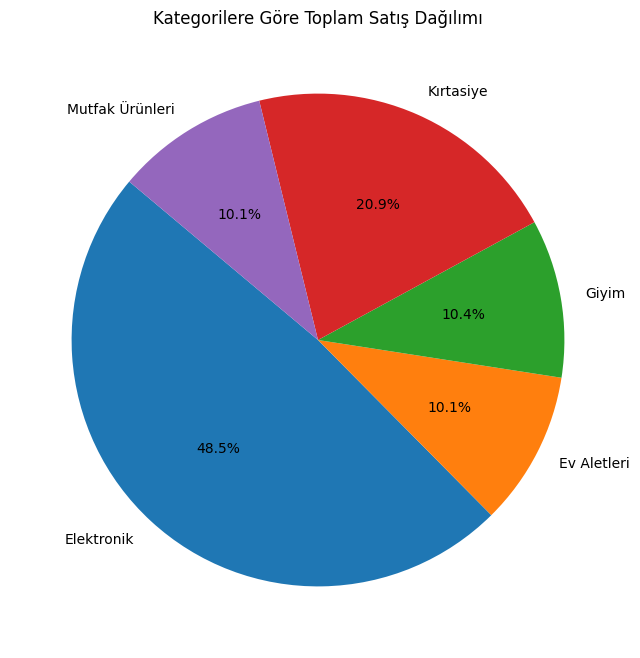

In [31]:
merged_data.groupby('kategori')['toplam_satis'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=140, legend=False, figsize=(8,8))
plt.title('Kategorilere Göre Toplam Satış Dağılımı')
plt.ylabel('')

Text(0, 0.5, '')

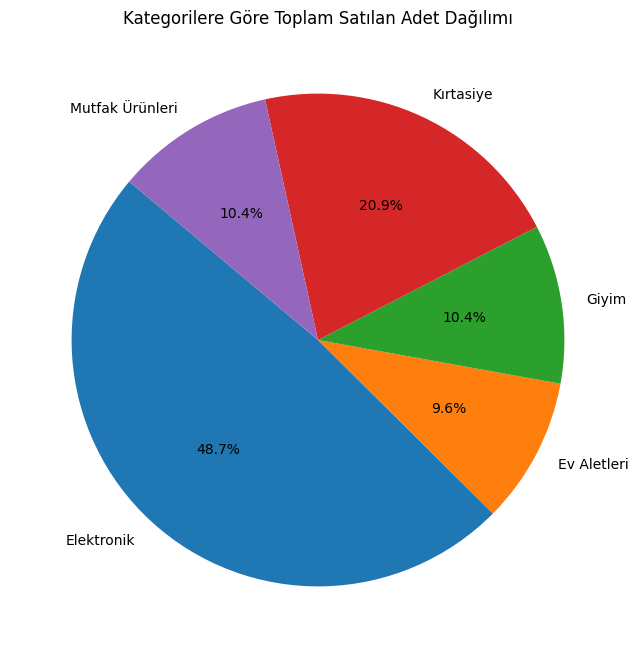

In [32]:
merged_data.groupby('kategori')['adet'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=140, legend=False, figsize=(8,8))
plt.title('Kategorilere Göre Toplam Satılan Adet Dağılımı')
plt.ylabel('')

C:\Users\talha\AppData\Local\Temp\ipykernel_8592\1265831348.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_sales = merged_data.groupby('yas_grubu')['toplam_satis'].sum().reset_index()


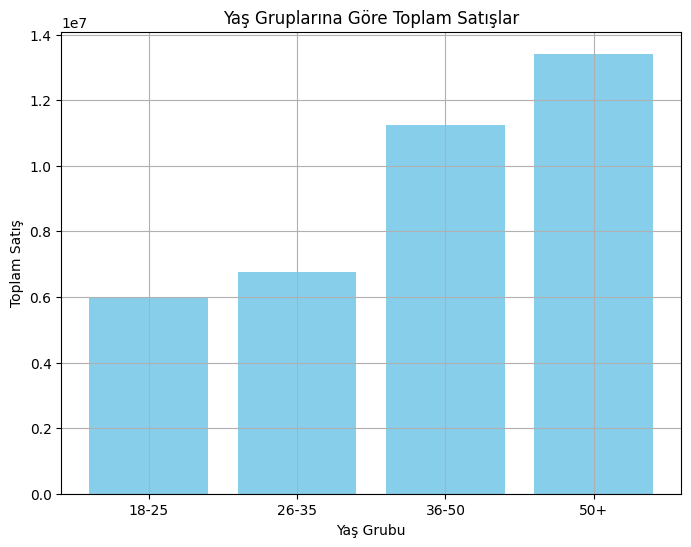

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Yaş gruplarını belirleyelim
bins = [17, 25, 35, 50, float('inf')]  # Yaş aralıkları: 18-25, 26-35, 36-50, 50+
labels = ['18-25', '26-35', '36-50', '50+']
merged_data['yas_grubu'] = pd.cut(merged_data['yas'], bins=bins, labels=labels, right=True)
musteri_data['yas_grubu'] = pd.cut(musteri_data['yas'], bins=bins, labels=labels, right=True)

# Yaş gruplarına göre toplam satışları hesaplayalım
age_group_sales = merged_data.groupby('yas_grubu')['toplam_satis'].sum().reset_index()

# Grafiği çizdirelim
plt.figure(figsize=(8, 6))
plt.bar(age_group_sales['yas_grubu'], age_group_sales['toplam_satis'], color='skyblue')
plt.title('Yaş Gruplarına Göre Toplam Satışlar')
plt.xlabel('Yaş Grubu')
plt.ylabel('Toplam Satış')
plt.grid(True)

# Grafiği göster
plt.show()


C:\Users\talha\AppData\Local\Temp\ipykernel_8592\1662962134.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_age_category = merged_data.groupby(['yas_grubu', 'kategori'])['toplam_satis'].sum().unstack()


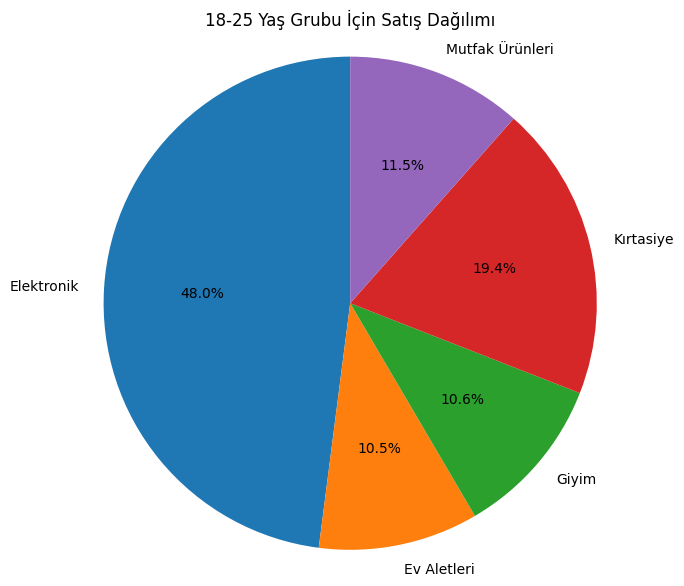

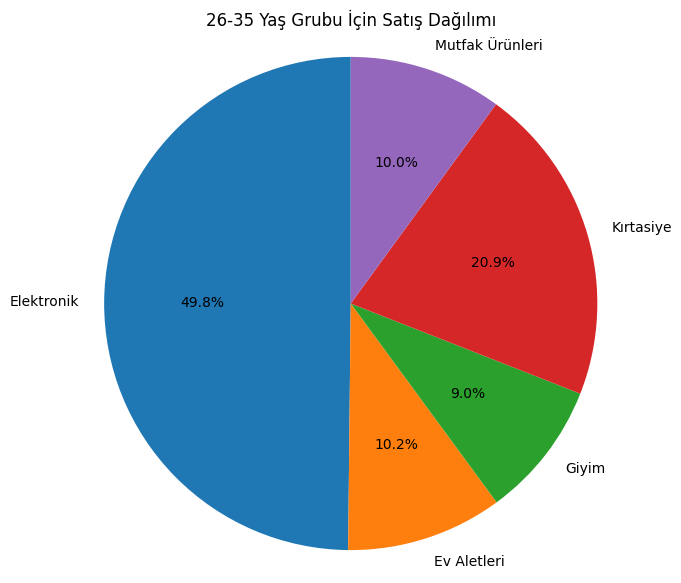

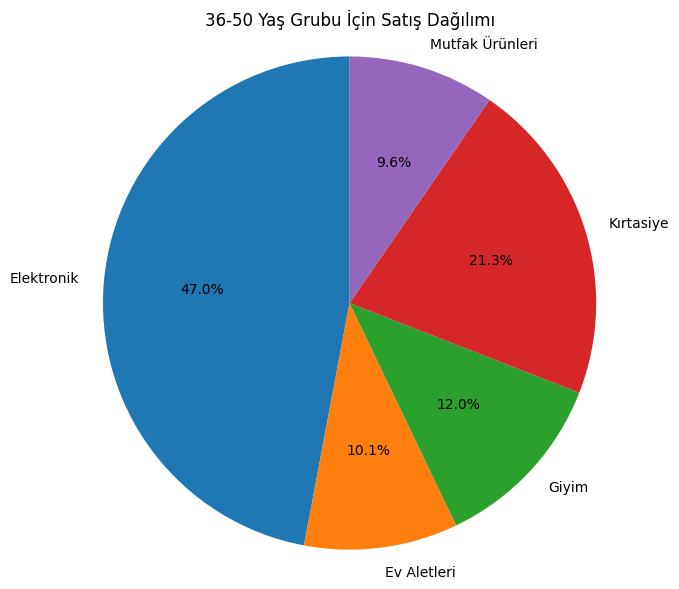

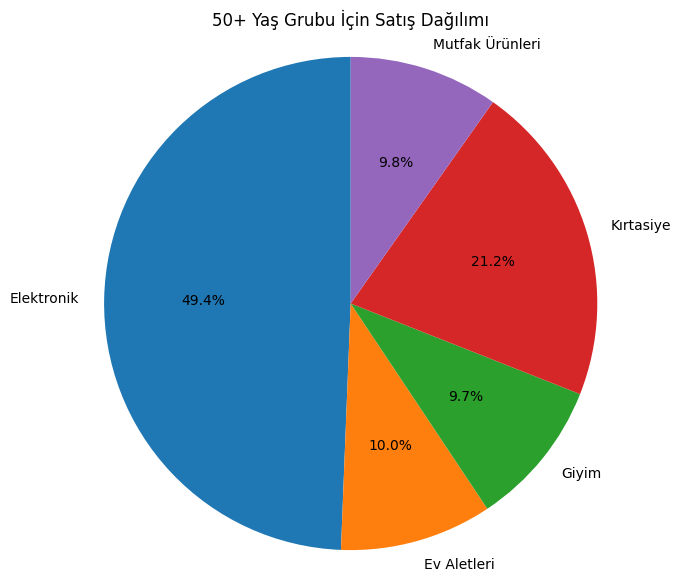

In [34]:
# Yas gruplarını ve kategori bazında toplam satışları gruplayalım
sales_by_age_category = merged_data.groupby(['yas_grubu', 'kategori'])['toplam_satis'].sum().unstack()

# Yas gruplarını alalım
age_groups = sales_by_age_category.index

# Her yaş grubu için pie chart çizelim
for age_group in age_groups:
    # İlgili yaş grubunun satış verilerini alıyoruz
    group_data = sales_by_age_category.loc[age_group]
    
    # Pie chart için çizim
    plt.figure(figsize=(7, 7))
    plt.pie(group_data, labels=group_data.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'{age_group} Yaş Grubu İçin Satış Dağılımı')
    plt.axis('equal')  # Daire şeklinde çizilmesi için
    plt.show()

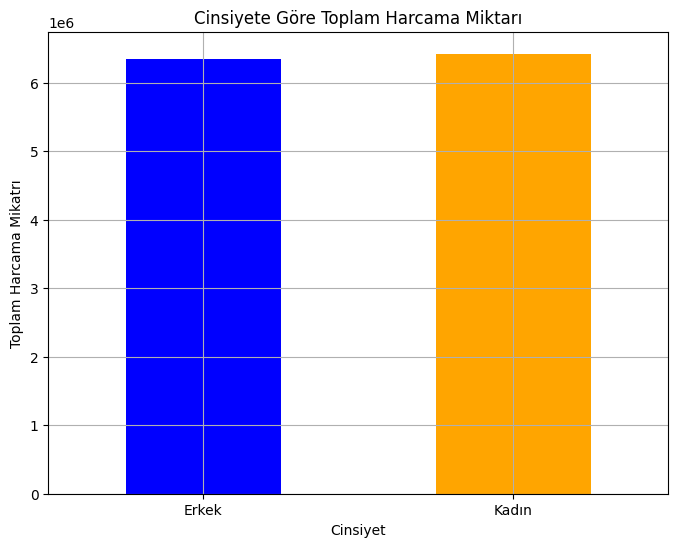

In [35]:
# Cinsiyet bazında toplam satışları hesaplayalım
sales_by_gender = musteri_data.groupby('cinsiyet')['harcama_miktari'].sum()

# Bar grafiği çizelim
plt.figure(figsize=(8, 6))
sales_by_gender.plot(kind='bar', color=['blue', 'orange'])
plt.title('Cinsiyete Göre Toplam Harcama Miktarı')
plt.xlabel('Cinsiyet')
plt.ylabel('Toplam Harcama Mikatrı')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\talha\AppData\Local\Temp\ipykernel_8592\3135410424.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  musteri_data.groupby(['cinsiyet', 'yas_grubu'])['harcama_miktari'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False, figsize=(8,8))


Text(0, 0.5, '')

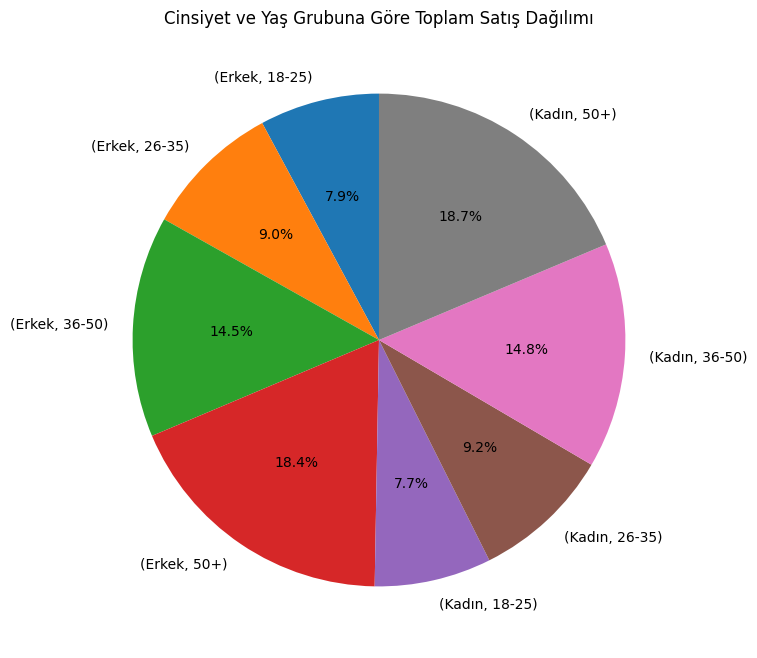

In [36]:
musteri_data.groupby(['cinsiyet', 'yas_grubu'])['harcama_miktari'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False, figsize=(8,8))
plt.title('Cinsiyet ve Yaş Grubuna Göre Toplam Satış Dağılımı')
plt.ylabel('')

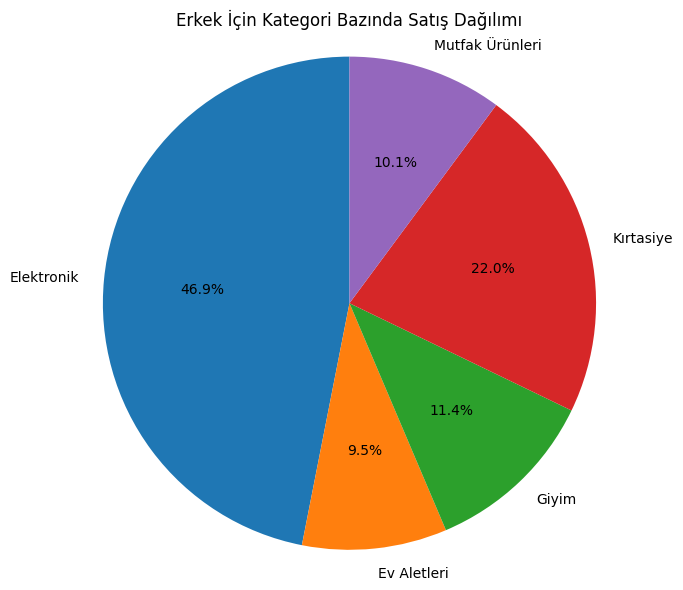

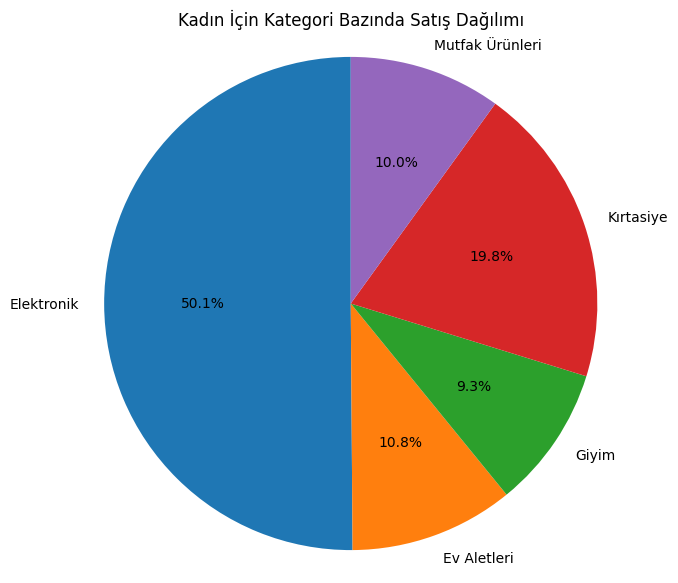

In [37]:
# Cinsiyet ve ürün bazında toplam satışları hesaplayalım
sales_by_gender_category = merged_data.groupby(['cinsiyet', 'kategori'])['toplam_satis'].sum().unstack()

# Cinsiyetleri teker teker ele alıp, her cinsiyet için pie chart çizelim
for gender in sales_by_gender_category.index:
    group_data = sales_by_gender_category.loc[gender]
    
    # Pie chart çizimi
    plt.figure(figsize=(7, 7))
    plt.pie(group_data, labels=group_data.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'{gender} İçin Kategori Bazında Satış Dağılımı')
    plt.axis('equal')  # Daire şeklinde
    plt.show()


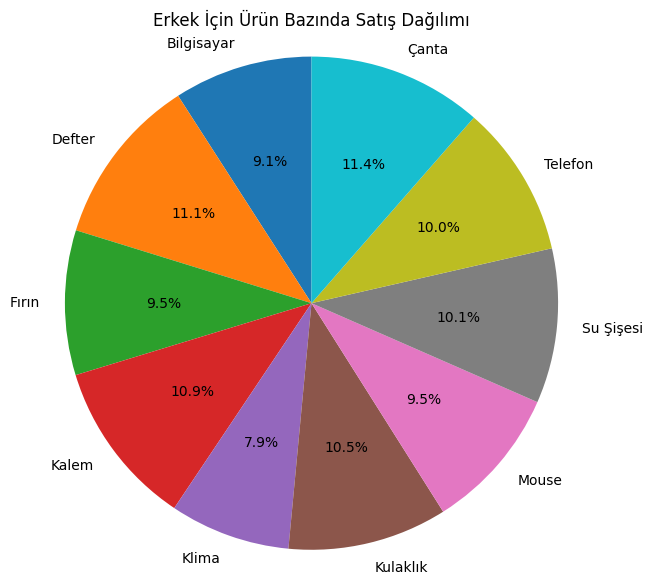

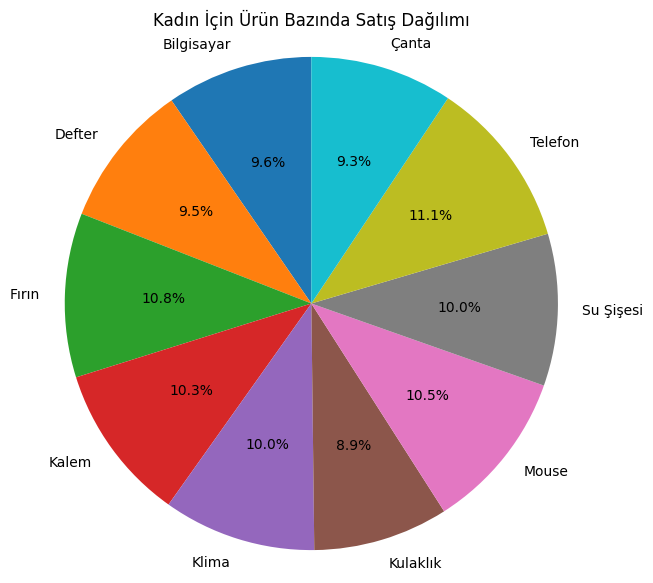

In [38]:
# Cinsiyet ve ürün bazında toplam satışları hesaplayalım
sales_by_gender_product = merged_data.groupby(['cinsiyet', 'ürün_adi'])['toplam_satis'].sum().unstack()

# Cinsiyetleri teker teker ele alıp, her cinsiyet için pie chart çizelim
for gender in sales_by_gender_product.index:
    group_data = sales_by_gender_product.loc[gender]
    
    # Pie chart çizimi
    plt.figure(figsize=(7, 7))
    plt.pie(group_data, labels=group_data.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'{gender} İçin Ürün Bazında Satış Dağılımı')
    plt.axis('equal')  # Daire şeklinde
    plt.show()


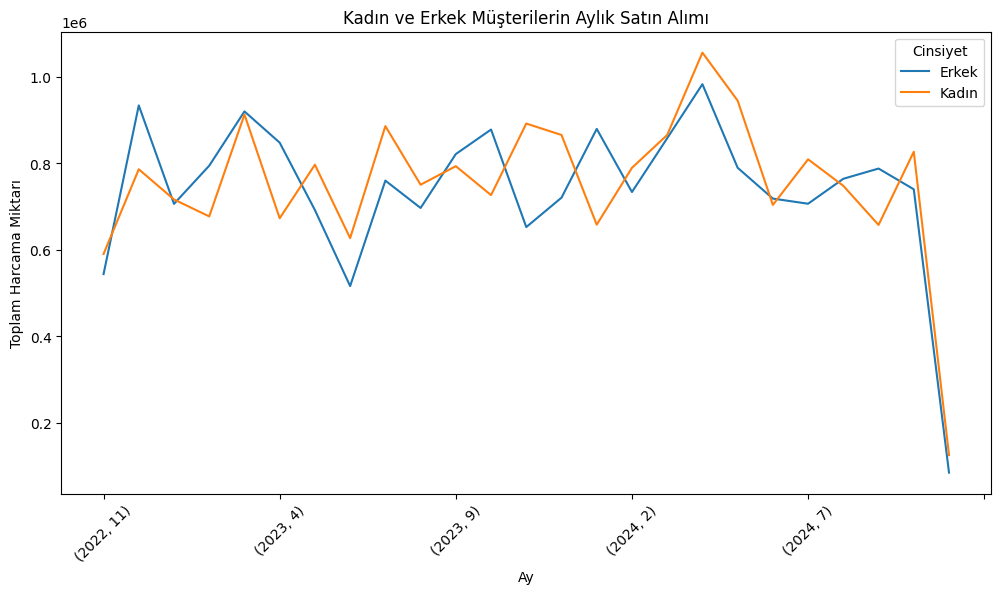

In [39]:
# Cinsiyete göre aylık harcama miktarını hesaplama
monthly_expense_gender = merged_data.groupby(['yil', 'ay', 'cinsiyet'])['toplam_satis'].sum().unstack()

# Grafik oluşturma
monthly_expense_gender.plot(kind='line', figsize=(12, 6))
plt.title('Kadın ve Erkek Müşterilerin Aylık Satın Alımı')
plt.xlabel('Ay')
plt.ylabel('Toplam Harcama Miktarı')
plt.xticks(rotation=45)
plt.legend(title='Cinsiyet')
plt.show()


# 4. soru

In [40]:
city_data=musteri_data.groupby('sehir')['harcama_miktari'].sum().reset_index()
city_data

,sehir,harcama_miktari
0,Adana,1567156.270
1,Ankara,1632071.240
2,Antalya,1482820.250
3,Bursa,1543966.940
4,Gaziantep,1680765.150
5,Konya,1604023.460
6,İstanbul,1544511.230
7,İzmir,1719480.530


In [41]:
cities_top_customers = musteri_data.sort_values(by=['sehir', 'harcama_miktari'], ascending=[True, False]).groupby('sehir').head(5)
print(cities_top_customers)

      musteri_id          isim cinsiyet  yas      sehir  harcama_miktari  \
4768        5208        Görklü    Erkek   20      Adana         4999.440   
2090        6790         Fenni    Erkek   28      Adana         4995.060   
3206        7376      Güçyeter    Erkek   29      Adana         4988.760   
3834        2239      Hürdoğan    Erkek   56      Adana         4987.850   
833         2056      Muktedir    Erkek   18      Adana         4956.860   
182         6736     Metinkaya    Kadın   52     Ankara         4995.060   
1368        1584        Bilkay    Erkek   60     Ankara         4993.770   
2888        5893       Necilal    Erkek   34     Ankara         4985.370   
3589        3372        Oganer    Kadın   58     Ankara         4984.200   
4941        6142          Tatu    Kadın   63     Ankara         4964.980   
919         7484         Satıa    Kadın   23    Antalya         4987.450   
1998        2692         Ekber    Kadın   61    Antalya         4985.900   
4293        

In [42]:
# Öncelikle, ürün ve tarih bazında satış verisini gruplandıralım
monthly_sales_change = merged_data.groupby(['ürün_kodu', 'yil', 'ay', 'kategori'])['toplam_satis'].sum().reset_index()

# Aylık satış değişim yüzdesini hesaplamak için önceki ay ile mevcut ay arasındaki farkı alacağız
monthly_sales_change['sales_change_pct'] = monthly_sales_change.groupby('ürün_kodu')['toplam_satis'].pct_change() * 100

# Ortalama satış değişim oranını hesaplayalım
average_sales_change = monthly_sales_change.groupby('ürün_kodu')['sales_change_pct'].mean().reset_index()

# Sonuçları görelim
print(average_sales_change)

  ürün_kodu  sales_change_pct
0      P010             8.148
1      P011            12.660
2      P018             0.461
3      P024            15.698
4      P032             5.206
5      P037             9.996
6      P063             6.586
7      P082             7.021
8      P087            10.165
9      P097             7.260


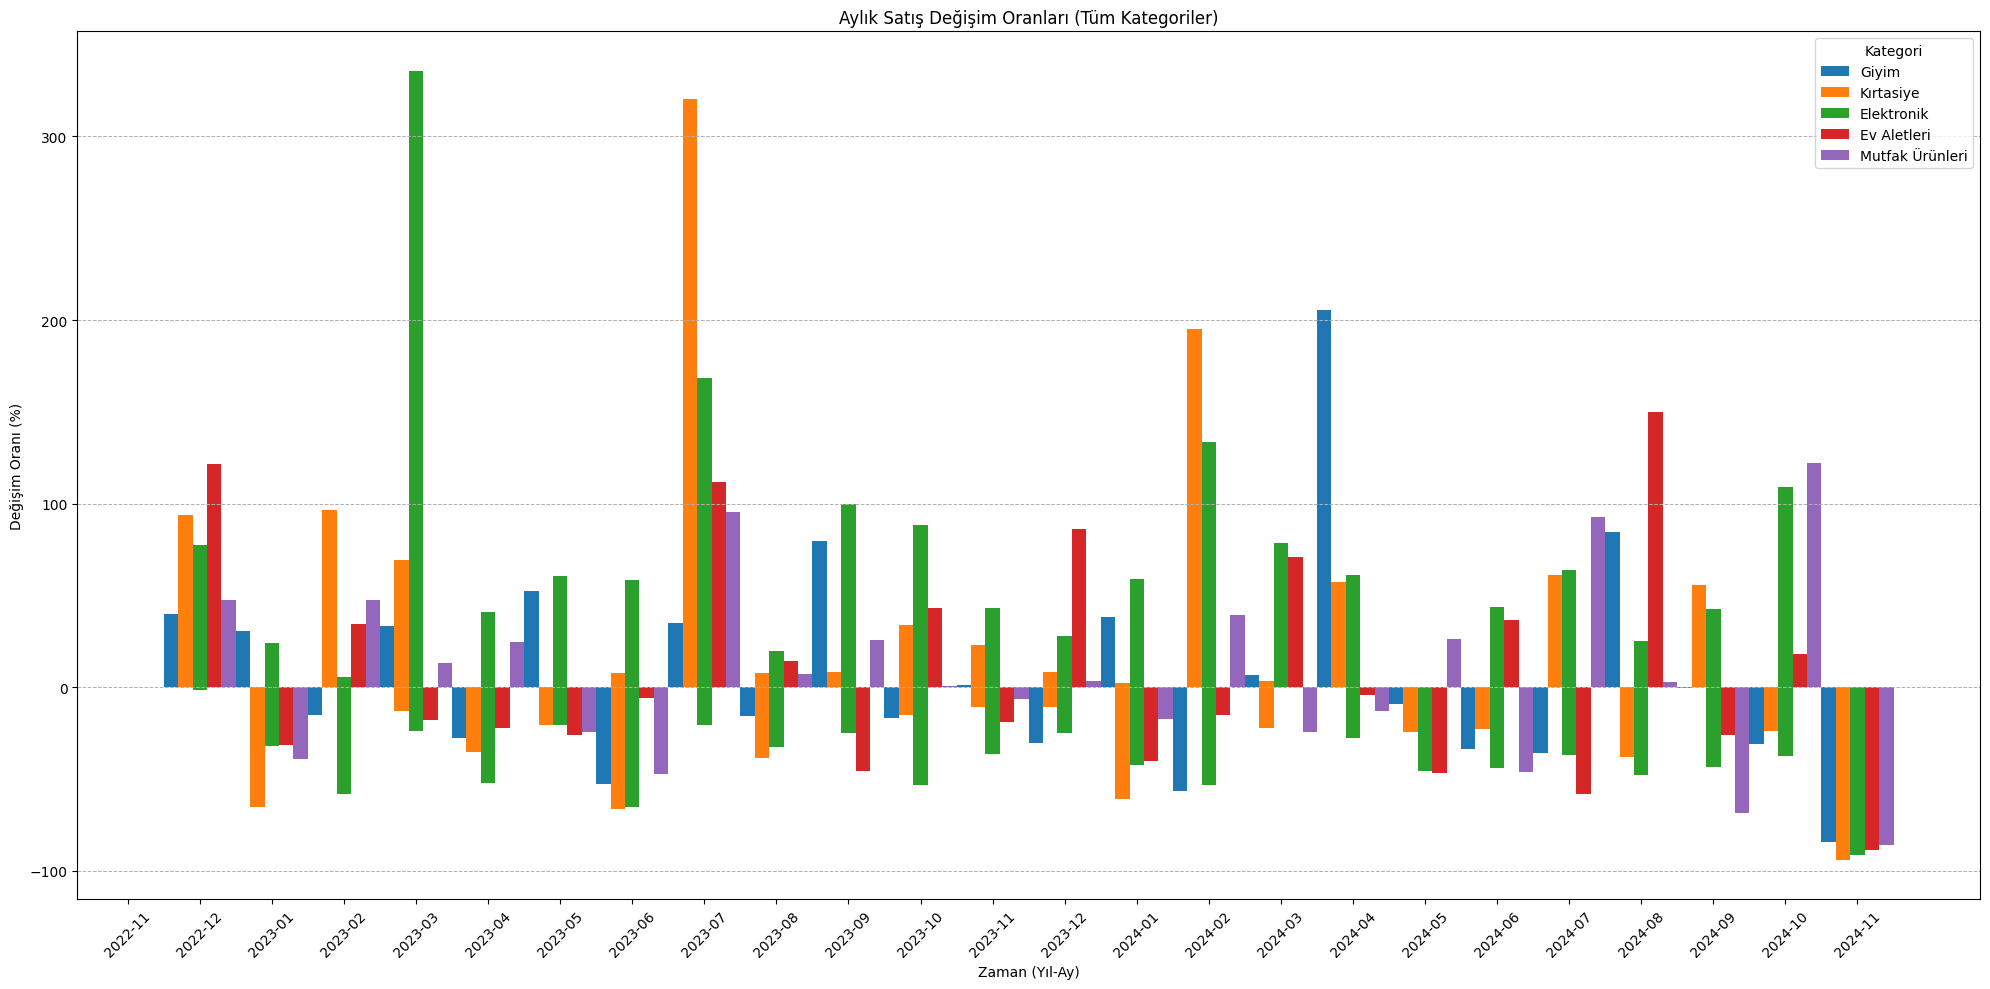

In [43]:
# Yıl-Ay formatını ekleyelim
monthly_sales_change['yil_ay'] = monthly_sales_change['yil'].astype(str) + '-' + monthly_sales_change['ay'].astype(str).str.zfill(2)

# Grafik başlatma
categories = monthly_sales_change['kategori'].unique()
unique_dates = monthly_sales_change['yil_ay'].unique()

# Her kategori ve yıl için bar grafik ayarları
plt.figure(figsize=(20, 10))
bar_width = 0.2  # Çubuk genişliği
x_positions = np.arange(len(unique_dates))  # X eksen pozisyonları

for i, category in enumerate(categories):
    category_data = monthly_sales_change[monthly_sales_change['kategori'] == category]
    
    # Değerleri X eksenine uygun şekilde yerleştir
    x_indices = [np.where(unique_dates == date)[0][0] for date in category_data['yil_ay']]
    sales_change_pct = category_data['sales_change_pct'].values  # Değişim oranları
    
    # Çubukları çiz
    plt.bar(np.array(x_indices) + i * bar_width, 
            sales_change_pct, 
            bar_width, 
            label=f'{category}')

# Grafik başlıkları ve etiketler
plt.title('Aylık Satış Değişim Oranları (Tüm Kategoriler)')
plt.xlabel('Zaman (Yıl-Ay)')
plt.ylabel('Değişim Oranı (%)')
plt.xticks(x_positions + (len(categories) - 1) * bar_width / 2, 
           unique_dates, rotation=45)  # Yıl-Ay bilgilerini X ekseninde göster
plt.legend(title='Kategori')
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Grafiği göster
plt.tight_layout()
plt.show()


# Bonus

Text(0.5, 1.0, 'Ürünların satış dağılımı')

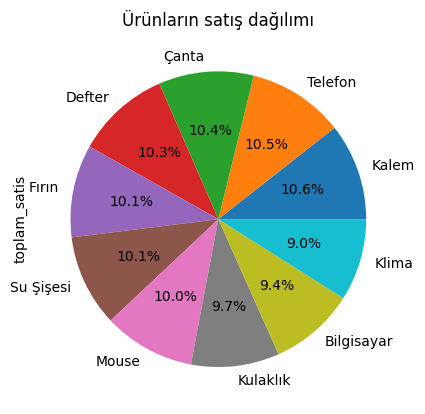

In [44]:
# Pareto analizi için ürünların satış dağılımı
merged_data.groupby('ürün_adi')['toplam_satis'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%')
plt.title('Ürünların satış dağılımı')

Text(0.5, 1.0, 'Ürünların adet dağılımı')

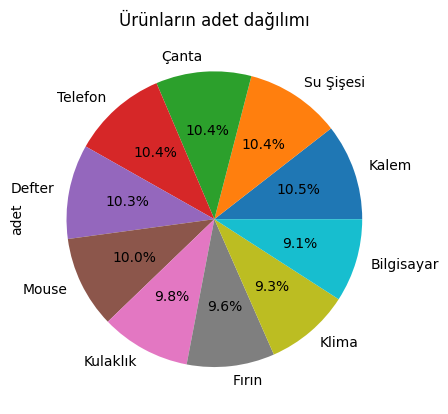

In [45]:
# Pareto analizi için ürünların satılan adet dağılımı
merged_data.groupby('ürün_adi')['adet'].sum().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%')
plt.title('Ürünların adet dağılımı')

Text(0.5, 1.0, 'Ürünların işlem dağılımı')

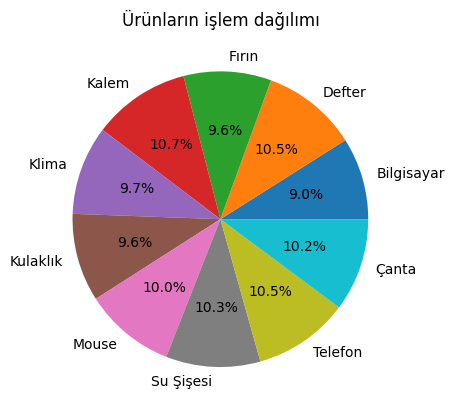

In [46]:
# Pareto analizi için ürünların kaç farklı işlemde görüldüğü dağılımı
merged_data.groupby('ürün_adi').size().plot(kind='pie', autopct='%1.1f%%')
plt.title('Ürünların işlem dağılımı')

In [47]:
# Müşterinin ilk satın alma tarihini belirleme
first_purchase = merged_data.groupby('musteri_id')['tarih'].min().reset_index()
first_purchase.columns = ['musteri_id', 'ilk_satin_alma']

# Müşterinin cohortunu ekleme
merged_data = merged_data.merge(first_purchase, on='musteri_id')
merged_data['cohort_ay'] = merged_data['ilk_satin_alma'].dt.to_period('M')

# Alışverişin yapıldığı ay
merged_data['alisveris_ay'] = merged_data['tarih'].dt.to_period('M')

# Cohort yaşı (ilk satın alma ile alışveriş arasındaki fark)
merged_data['cohort_yas'] = (merged_data['alisveris_ay'] - merged_data['cohort_ay']).apply(lambda x: x.n)

# Cohort analizi için gruplama
cohort_data = merged_data.groupby(['cohort_ay', 'cohort_yas'])['musteri_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_ay', columns='cohort_yas', values='musteri_id')

# Her cohortun ilk değerine göre yüzde oranını hesaplama
cohort_percentage = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0) * 100


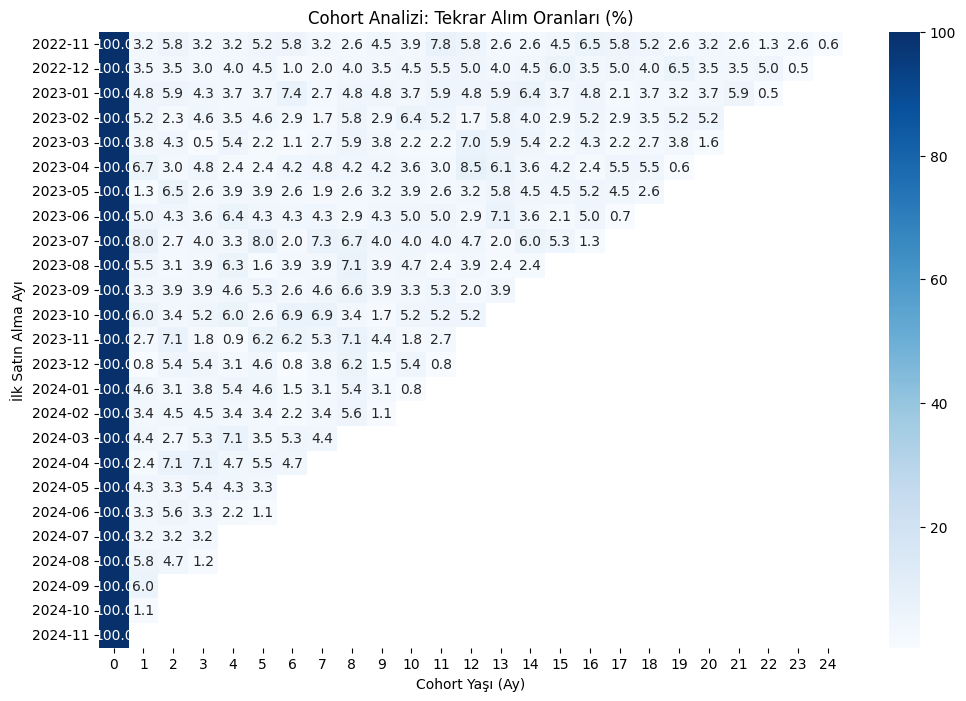

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_percentage, annot=True, fmt=".1f", cmap="Blues")
plt.title('Cohort Analizi: Tekrar Alım Oranları (%)')
plt.xlabel('Cohort Yaşı (Ay)')
plt.ylabel('İlk Satın Alma Ayı')
plt.show()


In [49]:
# Modeli tahmin etmek için kullanılacak bağımsız değişkenler (X) ve hedef değişken (y)
model_df = merged_data.copy()
model_df = model_df.sort_values('tarih')
X = model_df[['yil', 'ay', 'hafta']]
y = model_df['toplam_satis']  # Burada toplam satış tahmin edilecek

# Eğitim ve Test Verisine Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Modeli Oluşturma ve Eğitme
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [51]:
# Tahmin Yapma
y_pred = model.predict(X_test)

In [52]:
# Modeli Değerlendirme
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Absolute Error: 5413.060932284056
R-squared: -0.018237617315213228


In [53]:
monthly_model_df = model_df.groupby(['yil', 'ay'])['toplam_satis'].sum().reset_index()
monthly_model_df['shift'] = monthly_model_df.toplam_satis.shift(1)
monthly_model_df = monthly_model_df.dropna()

In [54]:
X = monthly_model_df[['yil', 'ay', 'shift']]
y = monthly_model_df['toplam_satis']  # Burada toplam satış tahmin edilecek

# Eğitim ve Test Verisine Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Modeli Oluşturma ve Eğitme
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [56]:
# Tahmin Yapma
y_pred = model.predict(X_test)

In [57]:
# Modeli Değerlendirme
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Absolute Error: 169750.79699999993
R-squared: 0.24922139828438084
